In [1]:
import json
import cpi
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor, to_graphviz,plot_importance
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
df_credits = pd.read_csv("tmdb_5000_credits.csv")
df_movies = pd.read_csv("tmdb_5000_movies.csv")
df_credits = df_credits.rename(columns={'movie_id': 'id'})
df_credits=df_credits.drop('title',axis=1)

# Merge the two dataframes based on the common 'id' column

df = df_credits.merge(df_movies, on='id')
print('shape df ',df.shape)

shape df  (4803, 22)


In [3]:
df.runtime.fillna(df.runtime.mean(),inplace=True)

In [4]:
df= df.loc[df.release_date.notnull()]

In [5]:
df.overview.fillna("Unsepecified",inplace=True)

In [6]:
outlier_thresh=1000
df=df[df.budget>outlier_thresh]
df=df[df.revenue>outlier_thresh]
len(df)

3211

In [7]:
zero_vals=df.apply(lambda x: sum(x==0),axis=0)
zero_vals[zero_vals>0]

vote_average    2
vote_count      2
dtype: int64

In [8]:
df=df[df.vote_count>0]
zero_vals=df.apply(lambda x: sum(x==0),axis=0)
zero_vals[zero_vals>0]

Series([], dtype: int64)

In [9]:
columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']

for col in columns: 
    df[col] = df[col].apply(json.loads)

df['release_date'] =  pd.to_datetime(df['release_date'], format ='%Y-%m-%d')

In [10]:
# We extract the names from the json data
for col in columns: 
    df[col] = df[col].map(lambda x:[i['name'] for i in x])

df.head()

,id,cast,crew,budget,genres,homepage,keywords,original_language,original_title,overview,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",...,"[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",...,[United States of America],2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,...,"[United Kingdom, United States of America]",2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,Spectre,6.3,4466
3,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,...,[United States of America],2012-07-16,1084939099,165.0,[English],Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",...,[United States of America],2012-03-07,284139100,132.0,[English],Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [11]:
df['year'] = df['release_date'].map(lambda dates: dates.year)
df['release_date'] = df['release_date'].map(lambda dates: datetime.datetime.strptime(str(dates), '%Y-%m-%d %H:%M:%S'))
df['day_of_year'] = df['release_date'].map(lambda dates: dates.timetuple().tm_yday)

df['year'] = df['release_date'].map(lambda dates: dates.year)
df['month'] = df['release_date'].map(lambda dates: dates.month)

In [12]:
columns = ['cast', 'crew']

for col in columns: 
    df[col] = df[col].apply(json.loads)
    
df['cast'] = df['cast'].map(lambda x:[ [i['name'],i['gender']] for i in x])
df['crew'] = df['crew'].map(lambda x:[ [i['name'],i['job'],i['department'],i['gender']] for i in x])


In [15]:
count_title = df.groupby('title').title.count()
count_title[count_title != 1]
double_title = count_title[count_title != 1].index.values
df.title = df.apply(lambda row: row.title+'_'+str(row.release_date) if (row.title in double_title) else row.title,axis = 1)


In [17]:
df["budget_adjusted"]=df.apply(lambda x: cpi.inflate(x["budget"],x["year"],to=2016),axis=1)
df["revenue_adjusted"]=df.apply(lambda x: cpi.inflate(x["revenue"],x["year"],to=2016),axis=1)


In [19]:
df_movie_prod = df[['production_companies','id']].explode('production_companies')
df_movie_prod = df_movie_prod.groupby('production_companies').count().sort_values(by='id', ascending=False)
df_movie_prod.columns=["count"]

In [21]:
interesting_prod = df_movie_prod.head(20).index.values
df.production_companies = df.production_companies.apply(lambda x :[prod for prod in x if prod in interesting_prod])
df.head()

,id,cast,crew,budget,genres,homepage,keywords,original_language,original_title,overview,...,status,tagline,title,vote_average,vote_count,year,day_of_year,month,budget_adjusted,revenue_adjusted
0,19995,"[[Sam Worthington, 2], [Zoe Saldana, 1], [Sigo...","[[Stephen E. Rivkin, Editor, Editing, 0], [Ric...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",...,Released,Enter the World of Pandora.,Avatar,7.2,11800,2009,344,12,2.651368e+08,3.118954e+09
1,285,"[[Johnny Depp, 2], [Orlando Bloom, 2], [Keira ...","[[Dariusz Wolski, Director of Photography, Cam...",300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",...,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007,139,5,3.472625e+08,1.112398e+09
2,206647,"[[Daniel Craig, 2], [Christoph Waltz, 2], [Léa...","[[Thomas Newman, Original Music Composer, Soun...",245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,...,Released,A Plan No One Escapes,Spectre,6.3,4466,2015,299,10,2.480907e+08,8.917844e+08
3,49026,"[[Christian Bale, 2], [Michael Caine, 2], [Gar...","[[Hans Zimmer, Original Music Composer, Sound,...",250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,...,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012,198,7,2.613385e+08,1.134145e+09
4,49529,"[[Taylor Kitsch, 2], [Lynn Collins, 1], [Saman...","[[Andrew Stanton, Screenplay, Writing, 2], [An...",260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",...,Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012,67,3,2.717920e+08,2.970259e+08


In [23]:
df.explode('keywords').groupby(['keywords'])[['id']].count().sort_values(by='id', ascending=False)[:10]


,id
keywords,
duringcreditsstinger,270
based on novel,175
woman director,165
aftercreditsstinger,148
murder,143
dystopia,130
independent film,127
violence,126
3d,91


In [24]:
interesting_keywords = ["woman director","independent film","based on novel","murder","violence","sex",
                      "nudity","superhero","biography","dystopia", "violence","revenge", "sport","teenager",
                        "3d","love","sequel"]

df.keywords = df.keywords.apply(lambda x :[keyword for keyword in x if keyword in interesting_keywords ])


In [26]:
df_prod_countries_count = df.explode('production_countries')['production_countries'].value_counts()
interesting_prod_countries = df_prod_countries_count.head(10).index.values
df.production_countries = df.production_countries.apply(lambda x :[prod for prod in x if prod in interesting_prod_countries])


In [27]:
df_lang_count = df.explode('spoken_languages')['spoken_languages'].value_counts()
interesting_lang = df_lang_count.head(5).index.values
df.spoken_languages = df.spoken_languages.apply(lambda x :[lang for lang in x if lang in interesting_lang])


In [28]:
df.columns

Index(['id', 'cast', 'crew', 'budget', 'genres', 'homepage', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'year', 'day_of_year', 'month',
       'budget_adjusted', 'revenue_adjusted'],
      dtype='object')

In [29]:
features_kept = ['title','keywords','budget','genres','popularity', 'production_companies', 
                'production_countries', 'year' ,'day_of_year','month','revenue', 'runtime', 'spoken_languages',
                'vote_average', 'vote_count',]

data = df[features_kept].set_index('title')
data=data[data["year"]>1960]
data.head()

,keywords,budget,genres,popularity,production_companies,production_countries,year,day_of_year,month,revenue,runtime,spoken_languages,vote_average,vote_count
title,,,,,,,,,,,,,,
Avatar,[3d],237000000,"[Action, Adventure, Fantasy, Science Fiction]",150.437577,"[Twentieth Century Fox Film Corporation, Dune ...","[United States of America, United Kingdom]",2009,344,12,2787965087,162.0,"[English, Español]",7.2,11800
Pirates of the Caribbean: At World's End,[],300000000,"[Adventure, Fantasy, Action]",139.082615,[Walt Disney Pictures],[United States of America],2007,139,5,961000000,169.0,[English],6.9,4500
Spectre,"[based on novel, sequel]",245000000,"[Action, Adventure, Crime]",107.376788,[Columbia Pictures],"[United Kingdom, United States of America]",2015,299,10,880674609,148.0,"[Français, English, Español, Deutsch]",6.3,4466
The Dark Knight Rises,[superhero],250000000,"[Action, Crime, Drama, Thriller]",112.312950,[Warner Bros.],[United States of America],2012,198,7,1084939099,165.0,[English],7.6,9106
John Carter,"[based on novel, 3d]",260000000,"[Action, Adventure, Science Fiction]",43.926995,[Walt Disney Pictures],[United States of America],2012,67,3,284139100,132.0,[English],6.1,2124


In [30]:
data.shape

(3145, 14)

In [31]:
col_to_explode = ['genres','keywords','production_companies','production_countries','spoken_languages']

for c in col_to_explode: 
    data_exploded = data.explode(c)
    dummies = pd.get_dummies(data_exploded[c]).reset_index().groupby('title').sum()
    data = dummies.join(data).drop(columns = c)

data.head()

,Deutsch,English,Español,Français,Pусский,Australia,Canada,China,France,Germany,...,Western,budget,popularity,year,day_of_year,month,revenue,runtime,vote_average,vote_count
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,0,1,0,1,0,0,0,0,0,0,...,0,7500000,45.610993,2009,198,7,60722734,95.0,7.2,2904
10 Cloverfield Lane,0,1,0,0,0,0,0,0,0,0,...,0,15000000,53.698683,2016,70,3,108286421,103.0,6.8,2468
10 Things I Hate About You,0,1,0,1,0,0,0,0,0,0,...,0,16000000,54.550275,1999,89,3,53478166,97.0,7.3,1701
102 Dalmatians,0,1,0,0,0,0,0,0,0,0,...,0,85000000,9.895061,2000,281,10,183611771,100.0,5.1,313
10th & Wolf,0,1,0,0,0,0,0,0,0,0,...,0,8000000,3.942464,2006,50,2,143451,107.0,6.3,24


In [32]:
data_no_cast=data.copy()

In [35]:
df_actors = df.set_index('title').cast.apply(pd.Series).stack().reset_index(level= 0).rename(columns={0:'cast'})
df_actors.head()

C:\Users\win 10\AppData\Local\Temp\ipykernel_24748\2287476635.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_actors = df.set_index('title').cast.apply(pd.Series).stack().reset_index(level= 0).rename(columns={0:'cast'})


,title,cast
0,Avatar,"[Sam Worthington, 2]"
1,Avatar,"[Zoe Saldana, 1]"
2,Avatar,"[Sigourney Weaver, 1]"
3,Avatar,"[Stephen Lang, 2]"
4,Avatar,"[Michelle Rodriguez, 1]"


In [36]:
df_actors['actor'] = df_actors['cast'].map(lambda x: x[0])
df_actors['actor_gender']  = df_actors['cast'].map(lambda x: x[1])
df_actors.drop(columns = 'cast',inplace = True)
df_actors.head()

,title,actor,actor_gender
0,Avatar,Sam Worthington,2
1,Avatar,Zoe Saldana,1
2,Avatar,Sigourney Weaver,1
3,Avatar,Stephen Lang,2
4,Avatar,Michelle Rodriguez,1


In [37]:
df_actor_movie = df_actors.merge(df, on='title', how='left').dropna()
df_actor_movie.head()

,title,actor,actor_gender,id,cast,crew,budget,genres,homepage,keywords,...,spoken_languages,status,tagline,vote_average,vote_count,year,day_of_year,month,budget_adjusted,revenue_adjusted
0,Avatar,Sam Worthington,2,19995,"[[Sam Worthington, 2], [Zoe Saldana, 1], [Sigo...","[[Stephen E. Rivkin, Editor, Editing, 0], [Ric...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,[3d],...,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,2009,344,12,2.651368e+08,3.118954e+09
1,Avatar,Zoe Saldana,1,19995,"[[Sam Worthington, 2], [Zoe Saldana, 1], [Sigo...","[[Stephen E. Rivkin, Editor, Editing, 0], [Ric...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,[3d],...,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,2009,344,12,2.651368e+08,3.118954e+09
2,Avatar,Sigourney Weaver,1,19995,"[[Sam Worthington, 2], [Zoe Saldana, 1], [Sigo...","[[Stephen E. Rivkin, Editor, Editing, 0], [Ric...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,[3d],...,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,2009,344,12,2.651368e+08,3.118954e+09
3,Avatar,Stephen Lang,2,19995,"[[Sam Worthington, 2], [Zoe Saldana, 1], [Sigo...","[[Stephen E. Rivkin, Editor, Editing, 0], [Ric...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,[3d],...,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,2009,344,12,2.651368e+08,3.118954e+09
4,Avatar,Michelle Rodriguez,1,19995,"[[Sam Worthington, 2], [Zoe Saldana, 1], [Sigo...","[[Stephen E. Rivkin, Editor, Editing, 0], [Ric...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,[3d],...,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,2009,344,12,2.651368e+08,3.118954e+09


In [38]:
df_actor_movie_count = df_actor_movie.groupby('actor')[['id']].count().sort_values(by ='id',ascending = False)
df_actor_movie_count.columns=["count"]
df_actor_movie_count.head()

,count
actor,
Samuel L. Jackson,29
Matt Damon,26
Morgan Freeman,23
Bill Hader,23
Jonah Hill,22


In [39]:
df_nb_actors = df_actors.groupby('title')[['actor']].count().sort_values(by='actor',ascending = False)
df_nb_actors.rename(columns={"actor": "# of actors"},inplace = True)
df_nb_actors.head(10)

,# of actors
title,
Rock of Ages,224
Mr. Smith Goes to Washington,213
Jason Bourne,208
Les Misérables,208
You Don't Mess with the Zohan,183
Real Steel,172
Star Trek,168
Oz: The Great and Powerful,159
The Dark Knight Rises,158


In [40]:
#add nb_of_actors as a feature
data = data.join(df_nb_actors)
data.head()

,Deutsch,English,Español,Français,Pусский,Australia,Canada,China,France,Germany,...,budget,popularity,year,day_of_year,month,revenue,runtime,vote_average,vote_count,# of actors
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,0,1,0,1,0,0,0,0,0,0,...,7500000,45.610993,2009,198,7,60722734,95.0,7.2,2904,23.0
10 Cloverfield Lane,0,1,0,0,0,0,0,0,0,0,...,15000000,53.698683,2016,70,3,108286421,103.0,6.8,2468,10.0
10 Things I Hate About You,0,1,0,1,0,0,0,0,0,0,...,16000000,54.550275,1999,89,3,53478166,97.0,7.3,1701,44.0
102 Dalmatians,0,1,0,0,0,0,0,0,0,0,...,85000000,9.895061,2000,281,10,183611771,100.0,5.1,313,5.0
10th & Wolf,0,1,0,0,0,0,0,0,0,0,...,8000000,3.942464,2006,50,2,143451,107.0,6.3,24,13.0


In [42]:
df_actor_revenue_sum = df_actor_movie.groupby('actor')[['revenue']].sum().sort_values(by ='revenue',ascending = False)
df_actor_revenue_sum.head()

,revenue
actor,
Stan Lee,15908121622
Samuel L. Jackson,12532724227
Frank Welker,9815288970
Hugo Weaving,9335318627
Cate Blanchett,8923467241


In [43]:
df_actor_vote = df_actor_movie.groupby('actor')[['vote_average']].mean().sort_values(by ='vote_average',ascending = False)
df_actor_vote.head()

,vote_average
actor,
Max Brandt,8.4
Richard S. Castellano,8.4
Simonetta Stefanelli,8.4
Lou Martini Jr.,8.4
Sal Richards,8.4


In [44]:
actors_top500 = df_actor_movie_count.head(500).index.values

In [45]:
df_actor_movie_top500 = df_actor_movie[df_actor_movie.actor.map(lambda x: x in actors_top500)].set_index('title')[['actor']]
df_actor_movie_top500.head()

,actor
title,
Avatar,Sam Worthington
Avatar,Zoe Saldana
Avatar,Sigourney Weaver
Avatar,Michelle Rodriguez
Avatar,Giovanni Ribisi


In [46]:
df_actor_movie_top500 = pd.get_dummies(df_actor_movie_top500)
df_actor_movie_top500.reset_index(inplace = True)
df_actor_movie_top500 = df_actor_movie_top500.groupby('title').sum()
df_actor_movie_top500.head()

,actor_Aaron Eckhart,actor_Aasif Mandvi,actor_Abigail Breslin,actor_Adam Sandler,actor_Alan Arkin,actor_Alan Rickman,actor_Alan Tudyk,actor_Albert Brooks,actor_Alec Baldwin,actor_Alex Borstein,...,actor_Willem Dafoe,actor_William Fichtner,actor_William H. Macy,actor_Woody Harrelson,actor_Yvette Nicole Brown,actor_Zach Galifianakis,actor_Zeljko Ivanek,actor_Zoe Saldana,actor_Zooey Deschanel,actor_Zoë Kravitz
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
10 Cloverfield Lane,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13 Hours: The Secret Soldiers of Benghazi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17 Again,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
data = data.join(df_actor_movie_top500, how= 'left') 
data.fillna(0, inplace = True) #some movie don't have 1 of the 500 top actors
data.head()

,Deutsch,English,Español,Français,Pусский,Australia,Canada,China,France,Germany,...,actor_Willem Dafoe,actor_William Fichtner,actor_William H. Macy,actor_Woody Harrelson,actor_Yvette Nicole Brown,actor_Zach Galifianakis,actor_Zeljko Ivanek,actor_Zoe Saldana,actor_Zooey Deschanel,actor_Zoë Kravitz
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,0,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
10 Cloverfield Lane,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Things I Hate About You,0,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102 Dalmatians,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10th & Wolf,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
df_crew = df.set_index('title').crew.apply(pd.Series).stack().reset_index(level= 0).rename(columns={0:'crew'})
df_crew.head()

C:\Users\win 10\AppData\Local\Temp\ipykernel_24748\1207727738.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_crew = df.set_index('title').crew.apply(pd.Series).stack().reset_index(level= 0).rename(columns={0:'crew'})


,title,crew
0,Avatar,"[Stephen E. Rivkin, Editor, Editing, 0]"
1,Avatar,"[Rick Carter, Production Design, Art, 2]"
2,Avatar,"[Christopher Boyes, Sound Designer, Sound, 0]"
3,Avatar,"[Christopher Boyes, Supervising Sound Editor, ..."
4,Avatar,"[Mali Finn, Casting, Production, 1]"


In [49]:
df_crew['crew_name'] = df_crew['crew'].map(lambda x: x[0])
df_crew['crew_job']  = df_crew['crew'].map(lambda x: x[1])
df_crew['crew_department']  = df_crew['crew'].map(lambda x: x[2])
df_crew['crew_gender']  = df_crew['crew'].map(lambda x: x[3])
df_crew.drop(columns = 'crew',inplace = True)
df_crew.head()

,title,crew_name,crew_job,crew_department,crew_gender
0,Avatar,Stephen E. Rivkin,Editor,Editing,0
1,Avatar,Rick Carter,Production Design,Art,2
2,Avatar,Christopher Boyes,Sound Designer,Sound,0
3,Avatar,Christopher Boyes,Supervising Sound Editor,Sound,0
4,Avatar,Mali Finn,Casting,Production,1


In [50]:
df_top_dep_crew=df_crew.groupby(['crew_department','crew_name'])[['title']].count().sort_values(by='title', ascending=False)
df_top_dep_crew.head(30)

title
crew_department   crew_name                 
Production        Mary Vernieu            73
Sound             Hans Zimmer             65
Production        Avy Kaufman             65
                  Francine Maisler        62
                  Harvey Weinstein        61
Sound             James Newton Howard     61
Production        Deborah Aquila          61
                  Bob Weinstein           60
                  Tricia Wood             55
Sound             Dan O'Connell           50
                  Kevin Kaska             50
Production        Steven Spielberg        50
Sound             John Williams           49
                  John Debney             49
Production        Bruce Berman            48
Sound             John Powell             47
                  Marco Beltrami          47
                  Danny Elfman            47
Production        John Papsidera          47
                  Scott Rudin             44
                  Arnon Milchan           44
                  Mindy Marin             44
Sound             Alan Silvestri          43
                  Christophe Beck         43
                  James Horner            42
Production        Sarah Finn              42
Costume & Make-Up Ve Neill                42
Production        Debra Zane              41
                  Tim Bevan               41
                  Joel Silver             41

In [51]:
df_crew_department = df_crew.groupby(['title','crew_department']).count().pivot_table(values='crew_name', index='title', columns='crew_department').fillna(0)
df_crew_department.head()

crew_department,Actors,Art,Camera,Costume & Make-Up,Crew,Directing,Editing,Lighting,Production,Sound,Visual Effects,Writing
title,,,,,,,,,,,,
(500) Days of Summer,0.0,3.0,5.0,2.0,2.0,2.0,2.0,0.0,8.0,9.0,0.0,2.0
10 Cloverfield Lane,0.0,9.0,6.0,6.0,6.0,2.0,5.0,3.0,6.0,6.0,7.0,3.0
10 Things I Hate About You,0.0,3.0,3.0,4.0,4.0,3.0,2.0,0.0,9.0,6.0,0.0,3.0
102 Dalmatians,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,7.0
10th & Wolf,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0


In [52]:
nb_crew_kept = 1000
top_crew = df_top_dep_crew.index.get_level_values('crew_name')[:nb_crew_kept].values
df_crew_top = df_crew[df_crew.crew_name.map(lambda x: x in top_crew)]
df_crew_top.crew_department.value_counts()

Production           5454
Sound                4581
Camera               1576
Art                  1358
Editing              1333
Costume & Make-Up    1140
Directing             684
Crew                  561
Writing               555
Visual Effects        387
Lighting               36
Name: crew_department, dtype: int64

In [54]:
df_crew_movie = df_crew.merge(df, on = 'title', how = 'left').dropna()
df_crew_movie.head()

,title,crew_name,crew_job,crew_department,crew_gender,id,cast,crew,budget,genres,...,spoken_languages,status,tagline,vote_average,vote_count,year,day_of_year,month,budget_adjusted,revenue_adjusted
0,Avatar,Stephen E. Rivkin,Editor,Editing,0,19995,"[[Sam Worthington, 2], [Zoe Saldana, 1], [Sigo...","[[Stephen E. Rivkin, Editor, Editing, 0], [Ric...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",...,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,2009,344,12,2.651368e+08,3.118954e+09
1,Avatar,Rick Carter,Production Design,Art,2,19995,"[[Sam Worthington, 2], [Zoe Saldana, 1], [Sigo...","[[Stephen E. Rivkin, Editor, Editing, 0], [Ric...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",...,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,2009,344,12,2.651368e+08,3.118954e+09
2,Avatar,Christopher Boyes,Sound Designer,Sound,0,19995,"[[Sam Worthington, 2], [Zoe Saldana, 1], [Sigo...","[[Stephen E. Rivkin, Editor, Editing, 0], [Ric...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",...,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,2009,344,12,2.651368e+08,3.118954e+09
3,Avatar,Christopher Boyes,Supervising Sound Editor,Sound,0,19995,"[[Sam Worthington, 2], [Zoe Saldana, 1], [Sigo...","[[Stephen E. Rivkin, Editor, Editing, 0], [Ric...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",...,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,2009,344,12,2.651368e+08,3.118954e+09
4,Avatar,Mali Finn,Casting,Production,1,19995,"[[Sam Worthington, 2], [Zoe Saldana, 1], [Sigo...","[[Stephen E. Rivkin, Editor, Editing, 0], [Ric...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",...,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,2009,344,12,2.651368e+08,3.118954e+09


In [55]:
df_crew_movie_exploded_genre = df_crew_movie.explode('genres')
df_crew_movie_exploded_genre.groupby(['genres','crew_name'])[['title']].count().sort_values(by='title',ascending= False).head(10)


,,title
genres,crew_name,
Action,Stan Lee,38
Adventure,George Lucas,32
Action,George Lucas,31
Adventure,Stan Lee,30
Drama,Francine Maisler,26
Animation,John Lasseter,25
Comedy,Judd Apatow,25
Adventure,Steven Spielberg,25
Family,John Lasseter,25


In [56]:
interesting_keywords = ["woman director","independent film","based on novel","murder","violence","sex",
                      "nudity","superhero","biography","dystopia", "violence","revenge", "sport","teenager",
                        "3d","love","sequel"]

df.keywords = df.keywords.apply(lambda x :[keyword for keyword in x if keyword in interesting_keywords ])


In [57]:
df_prod_countries_count = df.explode('production_countries')['production_countries'].value_counts()
df_prod_countries_count.head(10)

United States of America    2893
United Kingdom               431
Germany                      232
France                       196
Canada                       161
Australia                     77
Italy                         48
Spain                         43
Japan                         40
China                         37
Name: production_countries, dtype: int64

In [59]:
interesting_prod_countries = df_prod_countries_count.head(10).index.values
df.production_countries = df.production_countries.apply(lambda x :[prod for prod in x if prod in interesting_prod_countries])


In [60]:
df_lang_count = df.explode('spoken_languages')['spoken_languages'].value_counts()
df_lang_count.head(10)

English     3116
Français     303
Español      270
Deutsch      178
Pусский      147
Name: spoken_languages, dtype: int64

In [61]:
interesting_lang = df_lang_count.head(5).index.values
df.spoken_languages = df.spoken_languages.apply(lambda x :[lang for lang in x if lang in interesting_lang])


In [62]:
df_crew_top = df_crew_top.groupby(['title','crew_name']).count().reset_index()[['title','crew_name']].set_index('title')
df_crew_top.head()

,crew_name
title,
(500) Days of Summer,Mychael Danna
(500) Days of Summer,Piero Mura
10 Cloverfield Lane,Andy Kaplan
10 Cloverfield Lane,Phil Pastuhov
10 Cloverfield Lane,Will Files


In [63]:
df_crew_dummies = pd.get_dummies(df_crew_top)
df_crew_dummies.reset_index(inplace = True)
df_crew_dummies = df_crew_dummies.groupby('title').sum()
df_crew_dummies.head()

,crew_name_Aaron Glascock,crew_name_Aaron Williams,crew_name_Aaron Zigman,crew_name_Adam Dale,crew_name_Adam Jenkins,crew_name_Adam Milo Smalley,crew_name_Adam Sandler,crew_name_Ai-Ling Lee,crew_name_Akiva Goldsman,crew_name_Alan D'Angerio,...,crew_name_Wilma Garscadden-Gahret,crew_name_Woody Allen,crew_name_Wyck Godfrey,crew_name_Wylie Stateman,crew_name_Yann Delpuech,crew_name_Yolanda Toussieng,crew_name_Yuhon Ng,crew_name_Zach Staenberg,crew_name_Zachary Woodlee,crew_name_Zade Rosenthal
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10 Cloverfield Lane,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10 Things I Hate About You,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102 Dalmatians,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12 Rounds,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
data = data.join(df_crew_dummies, how= 'left').fillna(0)
data.head()

,Deutsch,English,Español,Français,Pусский,Australia,Canada,China,France,Germany,...,crew_name_Wilma Garscadden-Gahret,crew_name_Woody Allen,crew_name_Wyck Godfrey,crew_name_Wylie Stateman,crew_name_Yann Delpuech,crew_name_Yolanda Toussieng,crew_name_Yuhon Ng,crew_name_Zach Staenberg,crew_name_Zachary Woodlee,crew_name_Zade Rosenthal
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,0,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Cloverfield Lane,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Things I Hate About You,0,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102 Dalmatians,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10th & Wolf,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
#add number of crew per department 
data = data.join(df_crew_department, how = 'left').fillna(0)
data.head()

,Deutsch,English,Español,Français,Pусский,Australia,Canada,China,France,Germany,...,Camera,Costume & Make-Up,Crew,Directing,Editing,Lighting,Production,Sound,Visual Effects,Writing
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,0,1,0,1,0,0,0,0,0,0,...,5.0,2.0,2.0,2.0,2.0,0.0,8.0,9.0,0.0,2.0
10 Cloverfield Lane,0,1,0,0,0,0,0,0,0,0,...,6.0,6.0,6.0,2.0,5.0,3.0,6.0,6.0,7.0,3.0
10 Things I Hate About You,0,1,0,1,0,0,0,0,0,0,...,3.0,4.0,4.0,3.0,2.0,0.0,9.0,6.0,0.0,3.0
102 Dalmatians,0,1,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,7.0
10th & Wolf,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0


In [66]:
# add total number of crew
df_crew_number = df_crew.groupby('title').count()[['crew_name']].rename(columns = {'crew_name': '# crew'})
data = data.join(df_crew_number, how = 'left').fillna(0)
data.head()

,Deutsch,English,Español,Français,Pусский,Australia,Canada,China,France,Germany,...,Costume & Make-Up,Crew,Directing,Editing,Lighting,Production,Sound,Visual Effects,Writing,# crew
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,0,1,0,1,0,0,0,0,0,0,...,2.0,2.0,2.0,2.0,0.0,8.0,9.0,0.0,2.0,35.0
10 Cloverfield Lane,0,1,0,0,0,0,0,0,0,0,...,6.0,6.0,2.0,5.0,3.0,6.0,6.0,7.0,3.0,59.0
10 Things I Hate About You,0,1,0,1,0,0,0,0,0,0,...,4.0,4.0,3.0,2.0,0.0,9.0,6.0,0.0,3.0,37.0
102 Dalmatians,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,7.0,13.0
10th & Wolf,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0


Revenue prediction
Baseline
Our metric will be the adjusted R squared, our baseline will be predicting all movies revenues as the mean of revenues in the training set.

In [67]:
seed=42
split_size=0.2

In [68]:
def preprocess(data,y,x_to_drop,seed=seed,split_size=split_size):

    data.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
    y=data[y]
    X=data.drop(columns=x_to_drop)
    X = sm.add_constant(X)
    scaler = StandardScaler()
    X_transformed = scaler.fit_transform(X)
    X = pd.DataFrame(X_transformed, columns = X.columns,index=y.index)

    # splitting the data
    return train_test_split(X, y, test_size=split_size, random_state=seed)

In [69]:
def adjusted_r_2(y_test,y_pred,n,p):
    r2=r2_score(y_test,y_pred)
    return 1-(1-r2)*(n-1)/(n-p-1)

In [70]:
X_train, X_test, y_train, y_test=preprocess(data_no_cast,"revenue",["revenue","vote_count","vote_average","popularity"])


In [71]:
data_no_cast.shape

(3145, 79)

In [72]:
X_train.shape

(2516, 76)

In [73]:
y_pred=np.ones(y_test.shape) * np.mean(y_train)
print("Baseline")
adjusted_r_2(y_test,y_pred,len(y_train),1)

Baseline


-0.00472482198397306

Regression without cast
OLS

In [74]:
y_pred=sm.OLS(y_train, X_train).fit().predict(X_test)
print("OLS Score:",adjusted_r_2(y_test, y_pred,len(y_train),X_train.shape[1]))

OLS Score: -0.04580998112669987


Ridge Regression

Ridge Regression Score: 0.5131293050514707


Text(0, 0.5, 'Mean Squared Error')

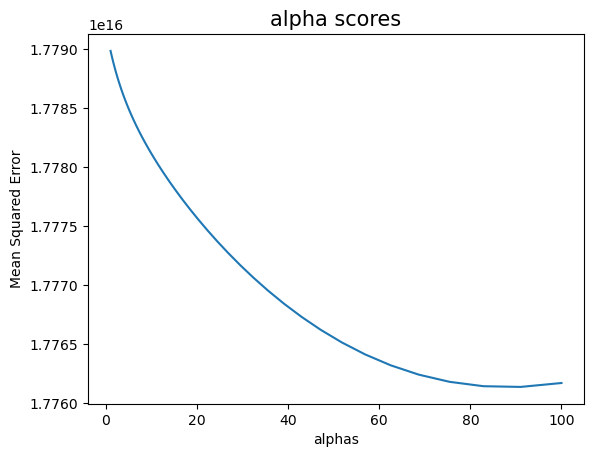

In [75]:
alphas=np.logspace(0,2,50)
clf = RidgeCV(alphas=alphas,store_cv_values=True).fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("Ridge Regression Score:",adjusted_r_2(y_test, y_pred,len(y_train),X_train.shape[1]))
plt.plot(alphas,np.apply_along_axis(np.mean,0,clf.cv_values_))
plt.title("alpha scores",fontsize=15)
plt.xlabel("alphas")
plt.ylabel("Mean Squared Error")

XGboost

In [76]:
regressor = XGBRegressor(colsample_bytree= 1, max_depth= 4, min_child_weight= 2,
                         subsample = 0.7, objective='reg:squarederror',verbosity=1,learning_rate=0.1,randomstate=42)
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)
print("XGBoost retained {} features".format(sum(regressor.feature_importances_>0)))
print("XGBoost Score:",adjusted_r_2(y_test, y_pred,len(y_train),sum(regressor.feature_importances_>0)))

C:\Users\win 10\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:54:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost retained 65 features
XGBoost Score: 0.546847583804113


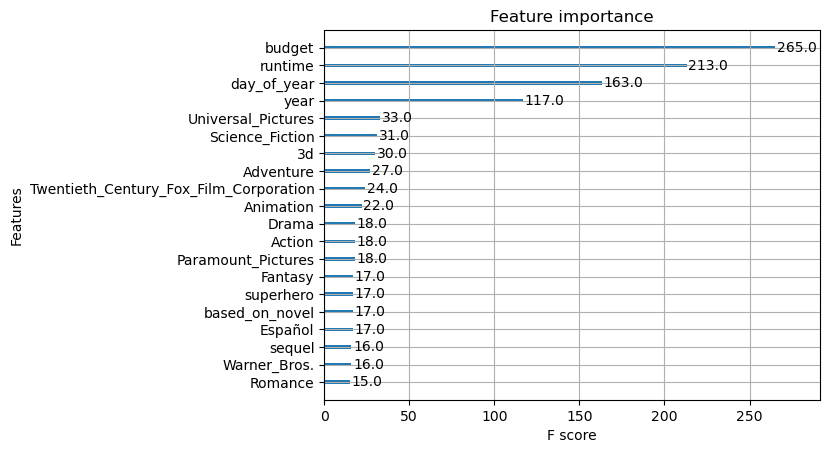

In [77]:
plot_importance(regressor,max_num_features = 20)
plt.show()

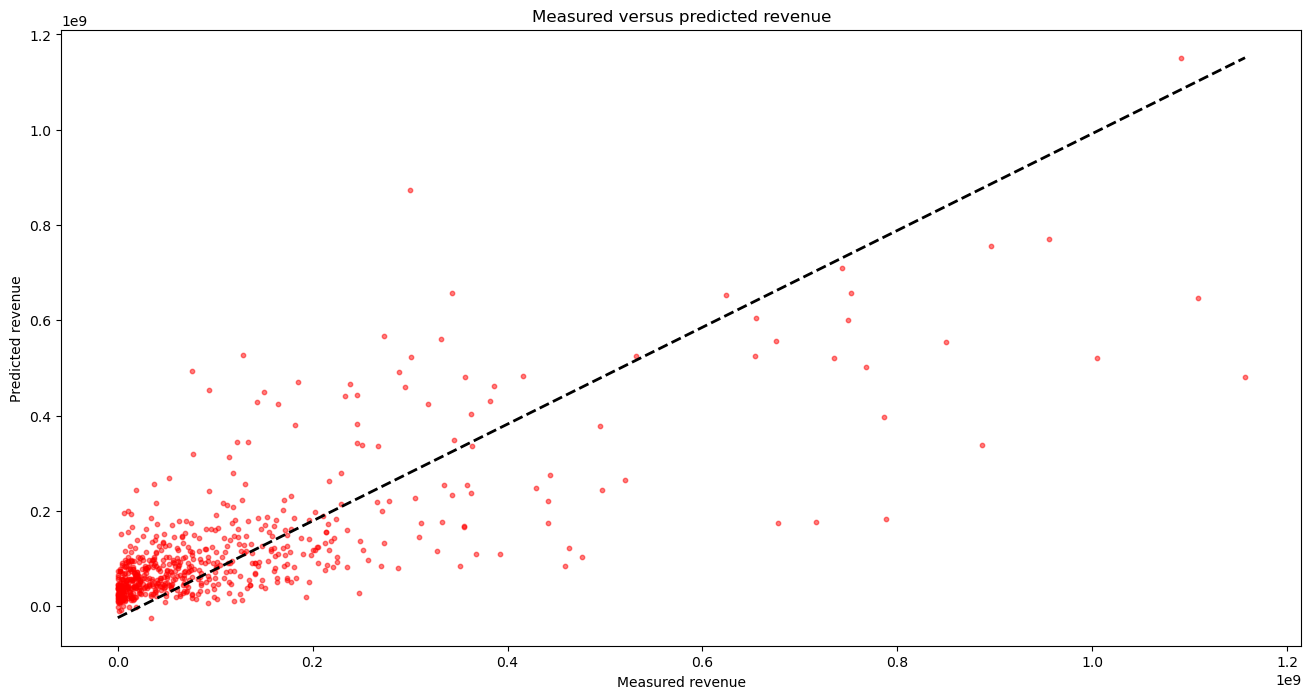

In [78]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(y_test, y_pred,alpha=0.5,s=10,c="red")
ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)
ax.set_xlabel('Measured revenue')
ax.set_ylabel('Predicted revenue')
plt.title('Measured versus predicted revenue')    
plt.show()

In [79]:
features_no_cast=pd.Series(regressor.feature_importances_,index=X_train.columns)

Regression with cast

In [80]:
X_train, X_test, y_train, y_test=preprocess(data,"revenue",["revenue","vote_count","vote_average","popularity"])
X_train.shape

(2516, 1568)

Ridge Regression

Ridge Regression Score: -0.35934799946714624


Text(0.5, 1.0, 'alpha scores')

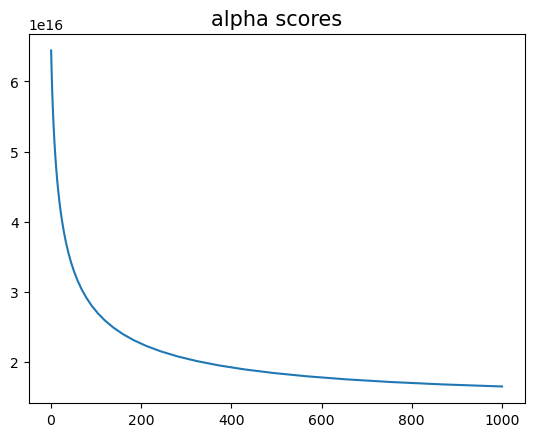

In [81]:
alphas=np.logspace(0,3,50)
clf = RidgeCV(alphas=alphas,store_cv_values=True).fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("Ridge Regression Score:",adjusted_r_2(y_test, y_pred,len(y_train),X_train.shape[1]))
plt.plot(alphas,np.apply_along_axis(np.mean,0,clf.cv_values_))
plt.title("alpha scores",fontsize=15)